<a href="https://colab.research.google.com/github/apd1995/AMP_matrix_recovery/blob/apd1995-blocksoft-9/updating_params.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import json
import time
from datetime import datetime, timezone, timedelta
from google.cloud import bigquery
import multiprocessing as mp
from google.colab import auth

In [ ]:
auth.authenticate_user()

In [ ]:
default_directory = 'Andrew+Apratim+Dave/experimental_design'
import sys
use_default_directory = input("Please enter Y if your directory is Andrew+Apratim+Dave/experimental_design.\nPlease enter N if not. ")
if use_default_directory == 'Y':
  import_directory = default_directory
elif use_default_directory == 'N':
  import_directory = input("Please enter your working directory in Google Drive. \nFor example, when you go to Google Drive, if your module is located in Folder1 -> Folder2, please write Folder1/Folder2. ")
sys.path.append('/content/drive/MyDrive/'+str(import_directory))
from experimental_design import logreg_data, kalish_optimal_two_point_logistic, white_optimal_two_point_logistic
%load_ext google.colab.data_table

Please enter Y if your directory is Andrew+Apratim+Dave/experimental_design.
Please enter N if not. Y


In [ ]:
def get_df_from_project(project_id, table_name):

  client = bigquery.Client(project=project_id)

  query = f"SELECT * FROM `{table_name}`"

  df = client.query(query).to_dataframe()

  return df

In [22]:
# df_integer_scale = get_df_from_project('hs-deep-lab-donoho', 'EMS.comr-N50-larger-grids')
# df_integer_scale

# df_AMP_coarse = get_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_blocksoft_02_1')
# df_AMP_coarse

df_AMP = get_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_blocksoft_09')
df_AMP

,nonzero_rows,num_measurements,signal_nrow,signal_ncol,mc,max_iter,err_tol,sparsity_tol,err_explosion_tol,sparsity,...,norm_2_2_rec,norm_2_infty_true,norm_2_infty_rec,soft_sparsity,nonzero_rows_rec,tpr,tnr,min_rel_err,iter_count,time_seconds
0,5,99,100,3,46,500,0.00001,0.0001,100,0.05,...,0.206747,1.411600,1.411597,0.05,5,1.000000,1.000000,0.000020,500,59.03
1,5,99,100,3,26,500,0.00001,0.0001,100,0.05,...,0.212276,1.459448,1.459448,0.05,5,1.000000,1.000000,0.000017,500,58.89
2,5,99,100,5,44,500,0.00001,0.0001,100,0.05,...,0.234767,1.539071,1.539070,0.05,5,1.000000,1.000000,0.000019,500,84.81
3,10,99,100,5,30,500,0.00001,0.0001,100,0.10,...,0.338224,1.506721,1.506718,0.10,10,1.000000,1.000000,0.000013,500,93.05
4,15,99,100,3,36,500,0.00001,0.0001,100,0.15,...,0.375366,1.789307,1.789305,0.15,15,1.000000,1.000000,0.000013,500,65.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279348,5,4,100,5,1,500,0.00001,0.0001,100,0.05,...,27.271831,1.624381,145.536829,0.21,21,0.810526,0.600000,1.000000,414,54.40
279349,5,4,100,5,16,500,0.00001,0.0001,100,0.05,...,29.334018,1.383191,194.299563,0.19,19,0.810526,0.200000,1.000000,83,13.26
279350,5,6,100,5,26,500,0.00001,0.0001,100,0.05,...,0.055332,1.103632,0.324983,0.19,19,0.810526,0.200000,0.985914,500,33.76
279351,5,5,100,3,44,500,0.00001,0.0001,100,0.05,...,0.547263,1.814594,3.096467,0.20,20,0.810526,0.400000,1.000000,500,26.08


Use the following function to use subsets of the full dataset, which is much easier to handle considering memory limitations.

In [ ]:
def subset_df_from_project(project_id, table_name, nonzero_rows):
  client = bigquery.Client(project=project_id)

  query = f"SELECT * FROM `{table_name}` WHERE nonzero_rows = {nonzero_rows}"

  df = client.query(query).to_dataframe()

  return df

# AMP_course_20 = subset_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_blocksoft_02', 20)
# AMP_course_20

AMP_course_5 = subset_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_blocksoft_02', 5)
AMP_course_5.to_csv("temp.csv")

In [ ]:
df_integer_scale = get_df_from_project('hs-deep-lab-donoho', 'EMS.comr-N50-larger-grids')

In [ ]:
def save_df_in_drive(output_df):

  output_name = input("Please write the name with which you'd like to store the output. ")
  default_directory = 'Andrew+Apratim+Dave/experimental_design'
  user_decision = input("Do you want to save your output in the default directory, that is, Andrew+Apratim+Dave/experimental_design? \nWrite Y for yes and N for no. ")

  if user_decision == "Y":
    output_df.to_csv("/content/drive/MyDrive/"+str(default_directory)+"/"+str(output_name))
    return
  elif user_decision == "N":
    output_directory = input("Please write the location you want your output file to be in, in Google Drive. \nIf it's Folder1 -> Folder2, write Folder1/Folder2 ")
    output_df.to_csv("/content/drive/MyDrive/"+str(output_directory)+"/"+str(output_name))
    return
  else:
    print("Invalid choice. Please enter only Y or N. ")
    return

# save_df_in_drive(AMP_course_20)
save_df_in_drive(df_AMP)
# del df_integer_scale

Please write the name with which you'd like to store the output. raw_data_AMP_blocksoft_larger.csv
Do you want to save your output in the default directory, that is, Andrew+Apratim+Dave/experimental_design? 
Write Y for yes and N for no. Y


In [ ]:
%load_ext rpy2.ipython

We need the bigrquery function to read gbq database. Upload the json file containing the key to session storage.

In [ ]:
%%R
# install.packages("bigrquery")
library(bigrquery)
Sys.setenv(GOOGLE_APPLICATION_CREDENTIALS = "key_file.json")

In [ ]:
%%R
project_id <- "hs-deep-lab-donoho"
sql_query <- "SELECT signal_nrow, signal_ncol FROM EMS.comr-N50-larger-grid"

result <- query_exec(sql_query, project = project_id, billing = project_id)

data_frame <- as.data.frame(result)


In [ ]:
%%R
library(tidyverse)
library(dplyr)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
%%R
#filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/raw_data_combined.csv"
#filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/raw_data_integer_scale_full.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/raw_data_AMP_blocksoft.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_course_20.csv"
# filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/raw_data_AMP_blocksoft_corrected.csv"
filename = "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/raw_data_AMP_blocksoft_larger.csv"
raw_data = read.csv(filename)
raw_data = subset(raw_data, select = -X)
raw_data = unique(raw_data)
row.names(raw_data) = 1:nrow(raw_data)
head(raw_data)

  nonzero_rows num_measurements signal_nrow signal_ncol mc max_iter err_tol
1           20                1         100           4  4      500   1e-05
2           10                1         100           4 31      500   1e-05
3            5                1         100           4 41      500   1e-05
4            5               80         100           3  9      500   1e-05
5            5               44         100           3 30      500   1e-05
6            5               83         100           3  5      500   1e-05
  sparsity_tol err_explosion_tol sparsity undersampling_ratio      rel_err
1        1e-04               100     0.20                0.01 1.000000e+00
2        1e-04               100     0.10                0.01 1.000000e+00
3        1e-04               100     0.05                0.01 2.119844e+00
4        1e-04               100     0.05                0.80 2.284598e-05
5        1e-04               100     0.05                0.44 2.519668e-05
6        1e-04    

In [ ]:
%%R
#helper functions
deno_integrand = function(x, B, tau_sq){
    tau = sqrt(tau_sq)
    return((sqrt(x) - tau)*dchisq(x, B))
}

deno_integral = function(B, tau_sq){
    return(integrate(deno_integrand, lower = tau_sq, upper = Inf, B, tau_sq)$value)
}

num_integrand = function(x, B, tau_sq){
    tau = sqrt(tau_sq)
    return((sqrt(x) - tau)^2*dchisq(x, B))
}

num_integral = function(B, tau_sq){
    return(integrate(num_integrand, lower = tau_sq, upper = Inf, B, tau_sq)$value)
}

h = function(B, tau_sq){
    return(sqrt(tau_sq)/deno_integral(B, tau_sq))
}

g = function(B, tau_sq){
    return(sqrt(tau_sq)*num_integral(B, tau_sq)/deno_integral(B, tau_sq))
}

tau_sq_optim_eqn = function(tau_sq, sparsity, B){
    return(h(B, tau_sq)+1-(1/sparsity))
}

#giving a huge upper bound 1e+50 instead of Inf as otherwise uniroot function breaks
tau_sq_optim = function(sparsity, B){
    res = uniroot(tau_sq_optim_eqn, c(0, 1e+100), sparsity, B)$root
    return(res)
}

#main function delivering delta PT value for given sparsity and B
predicted_delta_PT = function(sparsity, B){
    tau_sq = tau_sq_optim(sparsity, B)
    return((B+tau_sq+g(B, tau_sq))/(B*(1+h(B, tau_sq))))
}

c(predicted_delta_PT(sparsity = 0.85, B = 4), sqrt(tau_sq_optim(0.15, 5)), (1-0.15)*sqrt(5))

[1] 0.9801256 1.9835561 1.9006578


In [ ]:
%%R
get_LD50 = function(x, y){
    if(sum(y) == 0){
        return(1)
    }
    else if(sum(y) == length(y)){
        return(0)
    }
    else{
        logreg = glm(y~x, family = binomial(link = "logit"))
        intercept = logreg$coefficients[1]
        slope = logreg$coefficients[2]
        LD50 = unname(-intercept/slope)
        return(min(max(LD50, 0), 1))
        }
}


empirical_PT_df = function(df, sparsity_lower_bound, sparsity_upper_bound){
    dat = df %>%
    filter(sparsity>=sparsity_lower_bound, sparsity<=sparsity_upper_bound) %>%
    mutate(success = as.integer(rel_err < 100*err_tol)) %>%
    arrange(signal_nrow, signal_ncol, nonzero_rows, sparsity, num_measurements, undersampling_ratio, mc) %>%
    group_by(signal_nrow, signal_ncol, nonzero_rows, sparsity) %>%
    summarise(empirical_delta_PT = get_LD50(undersampling_ratio, success))

    # dat_small = dat %>%
    # filter(signal_nrow == min(dat$signal_nrow)) %>%
    # mutate(pred_delta_PT = mapply(predicted_delta_PT, sparsity, signal_ncol))

    # dat$pred_delta_PT = rep(dat_small$pred_delta_PT, as.integer(nrow(dat)/nrow(dat_small)))

    return(dat)
}

res = empirical_PT_df(raw_data, 0, 1)
#write.csv(res, "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_intger_scale.csv")

`summarise()` has grouped output by 'signal_nrow', 'signal_ncol',
'nonzero_rows'. You can override using the `.groups` argument.


In [ ]:
%%R
res = res %>%
mutate(pred_delta_PT = mapply(predicted_delta_PT, sparsity, signal_ncol))

In [ ]:
%%R
# Important: don't run this!
head(res)
# write.csv(res, "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_integer_scale.csv")
# write.csv(res, "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_AMP_blocksoft_threshold_corrected.csv")
write.csv(res, "/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_AMP_blocksoft_larger.csv")

In [ ]:
%%R
# res = read.csv("/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_integer_scale.csv", row.names = 1)
# res = read.csv("/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_AMP_blocksoft.csv", row.names = 1)
res

# A tibble: 57 × 6
# Groups:   signal_nrow, signal_ncol, nonzero_rows [57]
   signal_nrow signal_ncol nonzero_rows sparsity empirical_delta_PT
         <int>       <int>        <int>    <dbl>              <dbl>
 1         100           3            5     0.05              0.165
 2         100           3           10     0.1               0.276
 3         100           3           15     0.15              0.351
 4         100           3           20     0.2               0.442
 5         100           3           25     0.25              0.519
 6         100           3           30     0.3               0.602
 7         100           3           35     0.35              0.650
 8         100           3           40     0.4               0.725
 9         100           3           45     0.45              0.758
10         100           3           50     0.5               0.801
# ℹ 47 more rows
# ℹ 1 more variable: pred_delta_PT <dbl>
# ℹ Use `print(n = ...)` to see more rows


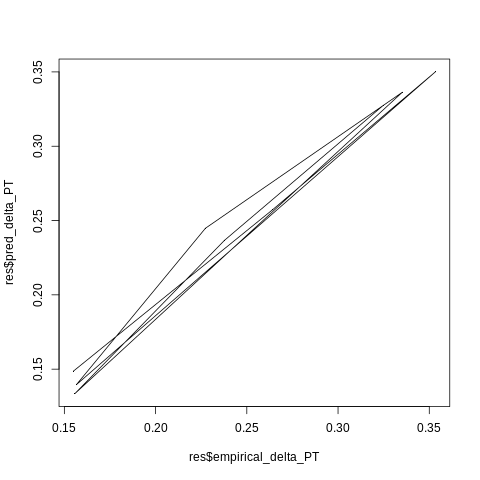

In [ ]:
%%R
plot(res$empirical_delta_PT, res$pred_delta_PT, pch = ".")
lines(res$empirical_delta_PT, res$pred_delta_PT)

In [ ]:
%%R
B = 3
res_small = res %>% filter(signal_ncol == B)
g2 <- ggplot(res_small, aes(x = sparsity, y = delta)) +
    labs(title = paste("Phase transition curves with ", B, "columns")) +
    theme(plot.title = element_text(hjust = 0.5)) +
    geom_line(aes(x = sparsity, y = empirical_delta_PT, color = as.factor(signal_nrow)))+
    scale_color_discrete(name = "no. of rows of signal", labels = "100") +
    geom_line(aes(x = sparsity, y = pred_delta_PT), color = "black")

g2

ggsave(paste("/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_PT_plot_B=", B, ".png", sep = ""), g2)

Saving 6.67 x 6.67 in image


In [ ]:
AMP_PT_df = pd.read_csv("/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/PT_data_AMP_blocksoft.csv", index_col = 0)
AMP_PT_df

,signal_nrow,signal_ncol,nonzero_rows,sparsity,empirical_delta_PT,pred_delta_PT
1,100,1,5,0.05,0.204887,0.203900
2,100,1,10,0.10,0.354998,0.328796
3,100,1,15,0.15,0.474997,0.427912
4,100,1,20,0.20,0.575218,0.511130
5,100,1,25,0.25,0.625004,0.582858
...,...,...,...,...,...,...
91,100,5,75,0.75,0.950000,0.943411
92,100,5,80,0.80,1.000000,0.963783
93,100,5,85,0.85,1.000000,0.979628
94,100,5,90,0.90,1.000000,0.990946


In [ ]:
PT_df['empirical_delta_PT']

1       0.077445
2       0.141939
3       0.140205
4       0.200532
5       0.201766
          ...   
1976    1.000000
1977    1.000000
1978    1.000000
1979    1.000000
1980    1.000000
Name: empirical_delta_PT, Length: 1980, dtype: float64

In [ ]:
def update_undersampling_int_grid(PT_df, signal_nrow, signal_ncol, nonzero_rows):

  empirical_PT_row = PT_df[(PT_df['signal_nrow'] == signal_nrow) & (PT_df['signal_ncol'] == signal_ncol) & (PT_df['nonzero_rows'] == nonzero_rows)]
  empirical_PT = empirical_PT_row['empirical_delta_PT'].item()
  undersampling_int_lower = max(1, int(signal_nrow * max(0, empirical_PT - 0.1)))
  undersampling_int_upper = min(signal_nrow - 1, int(signal_nrow * min(1, empirical_PT + 0.1)))
  return list(range(undersampling_int_lower, undersampling_int_upper + 1))

# update_undersampling_int_grid(empirical_PT_df, 50, 5, 4)
update_undersampling_int_grid(AMP_PT_df, 100, 2, 20)

[37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57]

In [ ]:
# coarser sparsity grid

def update_undersampling_int_grid_coarse(PT_df, signal_nrow, signal_ncol, sparsity):

  empirical_PT_row = PT_df[(PT_df['signal_nrow'] == signal_nrow) & (PT_df['B'] == signal_ncol) & (PT_df['sparsity'] == sparsity)]
  empirical_PT = empirical_PT_row['empirical_delta_PT'].item()
  undersampling_int_lower = max(1, int(signal_nrow * max(0, empirical_PT - 0.1)))
  undersampling_int_upper = min(signal_nrow - 1, int(signal_nrow * min(1, empirical_PT + 0.1)))
  return list(range(undersampling_int_lower, undersampling_int_upper + 1))

update_undersampling_int_grid_coarse(empirical_PT_df, 200, 1, 0.01)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35]

In [ ]:
def dict_experiment(PT_df) -> dict:
  # total_params = 0
  # exp = dict(table_name='AMP_matrix_recovery_blocksoft_25_test',
  #            base_index=0,
  #            db_url='sqlite:///data/EMS.db3',
  #            multi_res=[])
  # mr = exp['multi_res']
  # signal_nrow_grid = [100]
  # signal_ncol_grid = [3, 4, 5]
  # nonzero_rows_grid = [5, 10, 15]
  # for signal_nrow in signal_nrow_grid:
  #   for signal_ncol in signal_ncol_grid:
  #     for nonzero_rows in nonzero_rows_grid: #np.arange(1, signal_nrow):
  #       d = {
  #           'nonzero_rows': [round(nonzero_rows)],
  #           'num_measurements': [round(x) for x in np.linspace(5, 95, num = 19)], #[round(x) for x in np.arange(1, signal_nrow)],
  #           'signal_nrow': [round(signal_nrow)],
  #           'signal_ncol': [round(signal_ncol)],
  #           'mc': list(range(20)),
  #           'max_iter': [500],
  #           'err_tol': [1e-5],
  #           'sparsity_tol': [1e-4],
  #           'err_explosion_tol': [100]
  #           }
  #       mr.append(d)

  exp = dict(table_name='AMP_matrix_recovery_blocksoft_09',
             base_index=0,
             db_url='sqlite:///data/EMS.db3',
             multi_res=[])
  mr = exp['multi_res']
  signal_nrow_grid = [100]
  signal_ncol_grid = [3, 4, 5]
  nonzero_rows_grid = np.linspace(5, 95, num = 19)
  for signal_nrow in signal_nrow_grid:
    for signal_ncol in signal_ncol_grid:
      for nonzero_rows in nonzero_rows_grid: #np.arange(1, signal_nrow):
        d = {
            'nonzero_rows': [round(nonzero_rows)],
            'num_measurements': [round(x) for x in np.arange(1, signal_nrow)], #[round(x) for x in np.arange(1, signal_nrow)],
            'signal_nrow': [round(signal_nrow)],
            'signal_ncol': [round(signal_ncol)],
            'mc': list(range(50)),
            'max_iter': [500],
            'err_tol': [1e-5],
            'sparsity_tol': [1e-4],
            'err_explosion_tol': [100]
            }
        mr.append(d)

  # Following actually sent for computation
  # exp = dict(table_name='AMP_matrix_recovery_blocksoft_02',
  #            base_index=0,
  #            db_url='sqlite:///data/EMS.db3',
  #            multi_res=[])
  # mr = exp['multi_res']
  # signal_nrow_grid = [100]
  # signal_ncol_grid = [1, 2, 3, 4, 5]
  # for signal_nrow in signal_nrow_grid:
  #   for signal_ncol in signal_ncol_grid:
  #     for nonzero_rows in [20]:
  #       d = {
  #           'nonzero_rows': [round(nonzero_rows)],
  #           'num_measurements': [round(x) for x in update_undersampling_int_grid(PT_df, signal_nrow, signal_ncol, nonzero_rows)],
  #           'signal_nrow': [round(signal_nrow)],
  #           'signal_ncol': [round(signal_ncol)],
  #           'mc': list(range(50)),
  #           'max_iter': [500],
  #           'err_tol': [1e-5],
  #           'sparsity_tol': [1e-4],
  #           'err_explosion_tol': [100]
  #           }
  #       mr.append(d)

  # exp = dict(table_name='AMP_matrix_recovery_blocksoft_02',
  #            base_index=0,
  #            db_url='sqlite:///data/EMS.db3',
  #            multi_res=[])
  # mr = exp['multi_res']
  # signal_nrow_grid = [100]
  # signal_ncol_grid = [1, 2, 3, 4, 5]
  # for signal_nrow in signal_nrow_grid:
  #   for signal_ncol in signal_ncol_grid:
  #     for nonzero_rows in np.arange(5, signal_nrow, step = 5):
  #       d = {
  #           'nonzero_rows': [round(nonzero_rows)],
  #           'num_measurements': [round(x) for x in np.arange(5, signal_nrow, step = 5)],
  #           'signal_nrow': [round(signal_nrow)],
  #           'signal_ncol': [round(signal_ncol)],
  #           'mc': list(range(70)),
  #           'max_iter': [500],
  #           'err_tol': [1e-5],
  #           'sparsity_tol': [1e-4],
  #           'err_explosion_tol': [100]
  #           }
  #       mr.append(d)

  # signal_nrow_grid = [200]
  # signal_ncol_grid = [1, 2, 3, 4, 5]
  # sparsity_grid = [round(x, 2) for x in np.linspace(0.01, 0.99, 99)]
  # for signal_nrow in signal_nrow_grid:
  #   for signal_ncol in signal_ncol_grid:
  #     for sparsity in sparsity_grid:
  #       d = {
  #           'signal_nrow': [round(signal_nrow)],
  #           'signal_ncol': [round(signal_ncol)],
  #           'nonzero_rows': [round(signal_nrow * sparsity)],
  #           'num_measurements': [round(x) for x in update_undersampling_int_grid_coarse(PT_df, signal_nrow, signal_ncol, sparsity)],
  #           'mc': list(range(100)),
  #           'err_tol': [1e-5],
  #           'sparsity_tol': [1e-4]
  #           }
  #       mr.append(d)
  #       total_params = total_params + len(d['num_measurements'])
  # print(total_params)
  return exp

In [ ]:
# real experiment json creation
def dict_experiment_json(PT_df):

  exp = dict_experiment(PT_df)
  # with open('/content/drive/MyDrive/Andrew+Apratim+Dave/experimental_design/AMP_matrix_recovery_0002.json', 'w') as json_file:
  #   json.dump(exp, json_file, indent = 4)
  with open('AMP_matrix_recovery_blocksoft_09.json', 'w') as json_file:
      json.dump(exp, json_file, indent = 4)

dict_experiment_json(1)

In [ ]:
# test experiment json creation
def test_experiment_json():
  exp = dict_experiment(1)
  with open('AMP_matrix_recovery_blocksoft_test.json', 'w') as json_file:
    json.dump(exp, json_file, indent = 4)

test_experiment_json()

# Scratchpad

In [ ]:
np.arange(5, 100, step = 5)

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])

In [ ]:
AMP_raw_data = get_df_from_project('hs-deep-lab-donoho', 'EMS.AMP_matrix_recovery_blocksoft_02')

In [ ]:
df_small = AMP_raw_data[AMP_raw_data['nonzero_rows'] == 20]
df_small

,nonzero_rows,num_measurements,signal_nrow,signal_ncol,mc,max_iter,err_tol,sparsity_tol,err_explosion_tol,sparsity,...,norm_2_2_rec,norm_2_infty_true,norm_2_infty_rec,soft_sparsity,nonzero_rows_rec,tpr,tnr,min_rel_err,iter_count,time_seconds
71,20,5,100,4,6,500,0.00001,0.0001,100,0.2,...,78.678468,1.947473,331.439149,0.46,46,0.5250,0.40,1.000000,8,2.89
72,20,5,100,5,6,500,0.00001,0.0001,100,0.2,...,103.818871,1.540490,418.419878,0.73,73,0.2625,0.70,1.000000,8,2.93
73,20,5,100,1,7,500,0.00001,0.0001,100,0.2,...,56.720650,1.768059,249.735494,0.40,40,0.6375,0.55,1.000000,5,0.37
153,20,10,100,2,6,500,0.00001,0.0001,100,0.2,...,55.086349,2.340616,276.818876,0.51,51,0.4625,0.40,1.000000,18,1.50
154,20,10,100,1,4,500,0.00001,0.0001,100,0.2,...,63.737645,2.343204,352.614558,0.37,37,0.6125,0.30,1.000000,13,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13073,20,95,100,5,9,500,0.00001,0.0001,100,0.2,...,0.444018,1.450292,1.450287,0.20,20,1.0000,1.00,0.000008,24,8.38
13074,20,95,100,3,3,500,0.00001,0.0001,100,0.2,...,0.428329,1.463179,1.463181,0.20,20,1.0000,1.00,0.000008,22,5.68
13075,20,95,100,2,4,500,0.00001,0.0001,100,0.2,...,0.426301,1.540901,1.540901,0.20,20,1.0000,1.00,0.000009,21,1.70
13076,20,95,100,5,6,500,0.00001,0.0001,100,0.2,...,0.376608,1.326732,1.326731,0.20,20,1.0000,1.00,0.000009,22,11.88


In [ ]:
from scipy import integrate
from scipy.stats import chi2
from scipy.optimize import brentq
import numpy as np


def h_deno_integrand(x, tau, signal_ncol):
    return  (np.sqrt(x) - tau) * chi2.pdf(x, df = signal_ncol)


def h_deno_integral(tau, signal_ncol):
    return max(1e-10, integrate.quad(h_deno_integrand, tau**2, np.inf, args=(tau, signal_ncol))[0])


def h(tau, signal_ncol):
    numerator = tau
    denominator = h_deno_integral(tau, signal_ncol)
    return numerator/denominator


def h_centered(tau, sparsity, signal_ncol):
    return h(tau, signal_ncol) + 1 - (1/sparsity)


def minimax_tau_threshold(sparsity, signal_ncol):
    #root = newton(h_centered, 0, args=(sparsity, signal_ncol), maxiter = 1000, full_output=True)
    #root = fsolve(func = h_centered, x0 = -2, args = (sparsity, signal_ncol))
    root = brentq(h_centered, 0, 1e+10, args = (sparsity, signal_ncol))
    return root

def minimax_tau_threshold_approx(sparsity, signal_ncol):
    return (1-sparsity)*np.sqrt(signal_ncol)

minimax_tau_threshold(0.2, 10)


2.5300025247020024

In [ ]:
%%R
sqrt(tau_sq_optim(0.2, 10))

[1] 2.530003


In [ ]:
torch.func.grad

<function torch.func.grad(func: Callable, argnums: Union[int, Tuple[int, ...]] = 0, has_aux: bool = False) -> Callable>